In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import os
plt.rcParams['figure.dpi'] = 100

In [2]:
r = 13
extent = 10

In [3]:
def symetric_round(x, n=0):
    return np.where(x > 0, np.ceil(x), np.floor(x))

boo_lst = ['false', ' true']
def mask_dict_to_lua(mask_dict, filename):
    with open(filename, 'w') as f:
        f.write(f'-- This file was generated by a python script on {datetime.datetime.now().date()}\n\n\n')
        f.write('--- @type table<integer, Mask>\n')
        f.write('local masks = {}\n\n')
        
        for direction, dict_mask in mask_dict.items():
            f.write(f'masks[{direction}] = {{}}\n')
            for d, elements in dict_mask.items():
                f.write(f'masks[{direction}][{d}] = {{')
                for i, element in enumerate(elements):
                    x, y = element["pos"]
                    overlap = int(element["o"])
                    u, v = element["n"]
                    if i % 3 == 0:
                        f.write('\n   ')
                    f.write(f' {{pos={{x={x:2d}, y={y:2d}}}, n={{x={u:.6f}, v={v:.6f}}}, o={boo_lst[overlap]}}},')
                f.write('\n}\n\n')
                
        f.write('return masks\n')

# Curved Rails

In [4]:
x2, y2 = np.mgrid[-27.5:28.5, -27.5:28.5]
theta2 = np.arctan2(y2, x2)
r2 = np.sqrt(x2**2 + y2**2)

normals2 = np.array([-np.sin(theta2), np.cos(theta2)])

r2 = r2 - r
r2_sign = np.sign(r2)
r2_abs = np.abs(r2)
r2 = symetric_round(r2,0)

r2_bool = np.logical_and(r2_abs >= -extent, r2_abs <= extent)
r2[np.logical_not(r2_bool)] = np.nan
r2[r2 == 0] = r2_sign[r2 == 0]
r2[r2 == 0] = np.nan

x_circle = np.cos(np.linspace(0, np.pi*2, 100)) * r
y_circle = np.sin(np.linspace(0, np.pi*2, 100)) * r

angles = np.arange(0, 16, 1) * np.pi / 8 - np.pi


(0.0, 27.0)

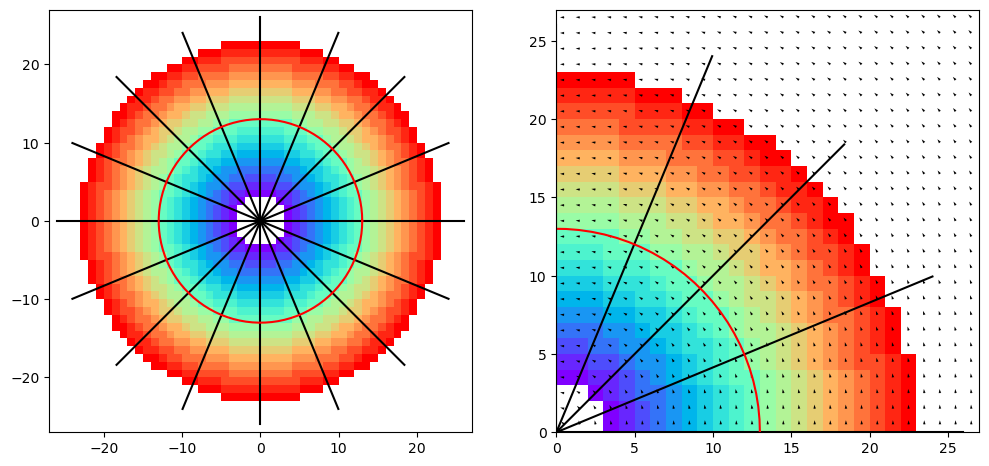

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12, 24))
for ax in axs:
    for angle in angles:
        x = np.cos(angle) * r*2
        y = np.sin(angle) * r*2
        ax.plot([0, x], [0, y], color='black')
    
    ax.plot(x_circle, y_circle, color='red')
    ax.pcolormesh(x2, y2, r2, cmap='rainbow')
    ax.set_aspect('equal')
    
ax = axs[0]
ax.set_xlim(-27, 27)
ax.set_ylim(-27, 27)

ax = axs[1]
ax.quiver(x2, y2, normals2[0], normals2[1], color='black')
ax.set_xlim(0, 27)
ax.set_ylim(0, 27)


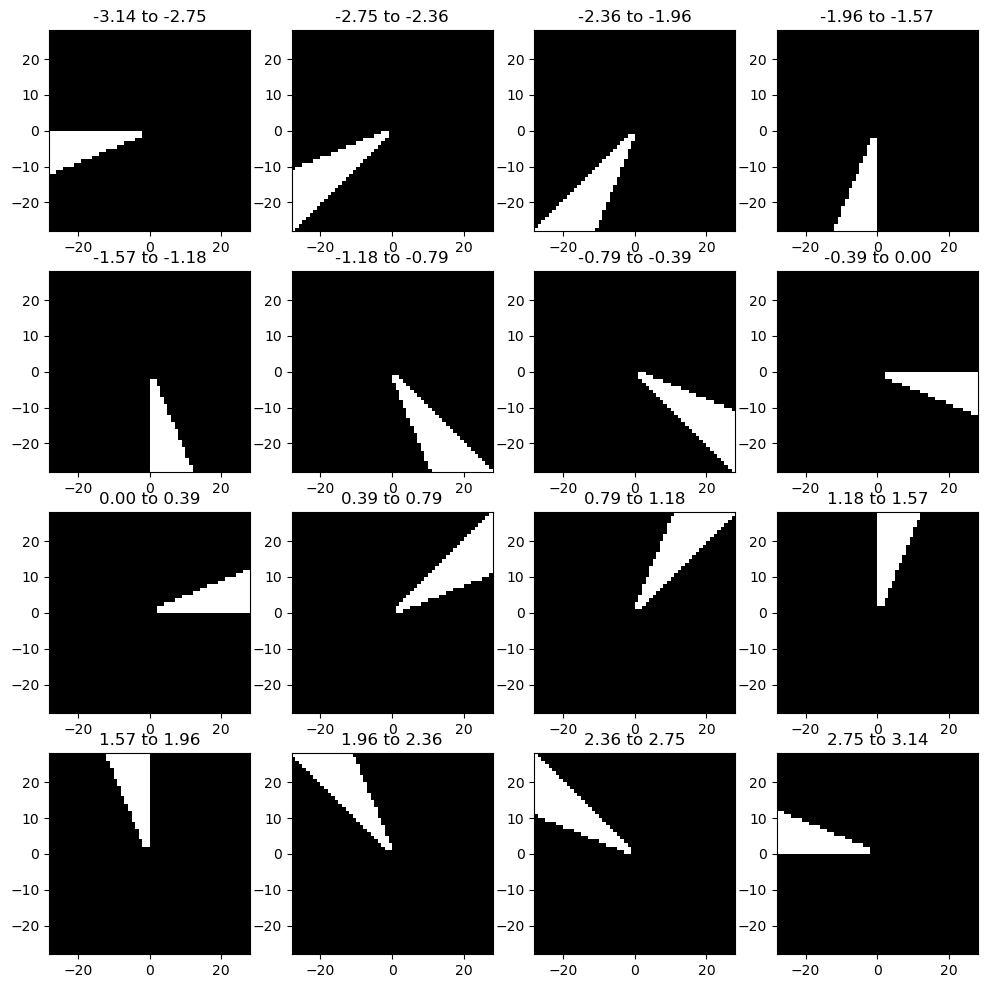

In [6]:
angle_pairs = [x for x in zip(angles, angles[1:])]
angle_pairs.append((angles[-1], -angles[0]))
masks = []
for angle1, angle2 in angle_pairs:
    mask = np.zeros_like(theta2, dtype=bool)
    for x_offset in [-0.5, 0.5]:
        for y_offset in [-0.5, 0.5]:
            tmp_theta2 = np.arctan2(y2+x_offset, x2+y_offset)
            tmp_mask = np.logical_and(tmp_theta2 > angle1, tmp_theta2 < angle2)
            mask = np.logical_or(mask, tmp_mask)
    masks.append(mask)
    
fig, axs = plt.subplots(4,4, figsize=(12, 12))
for i, mask in enumerate(masks):
    ax = axs[i//4, i%4]
    ax.pcolormesh(x2, y2, mask, cmap='gray')
    ax.set_aspect('equal')
    ax.set_title(f'{angle_pairs[i][0]:.2f} to {angle_pairs[i][1]:.2f}')

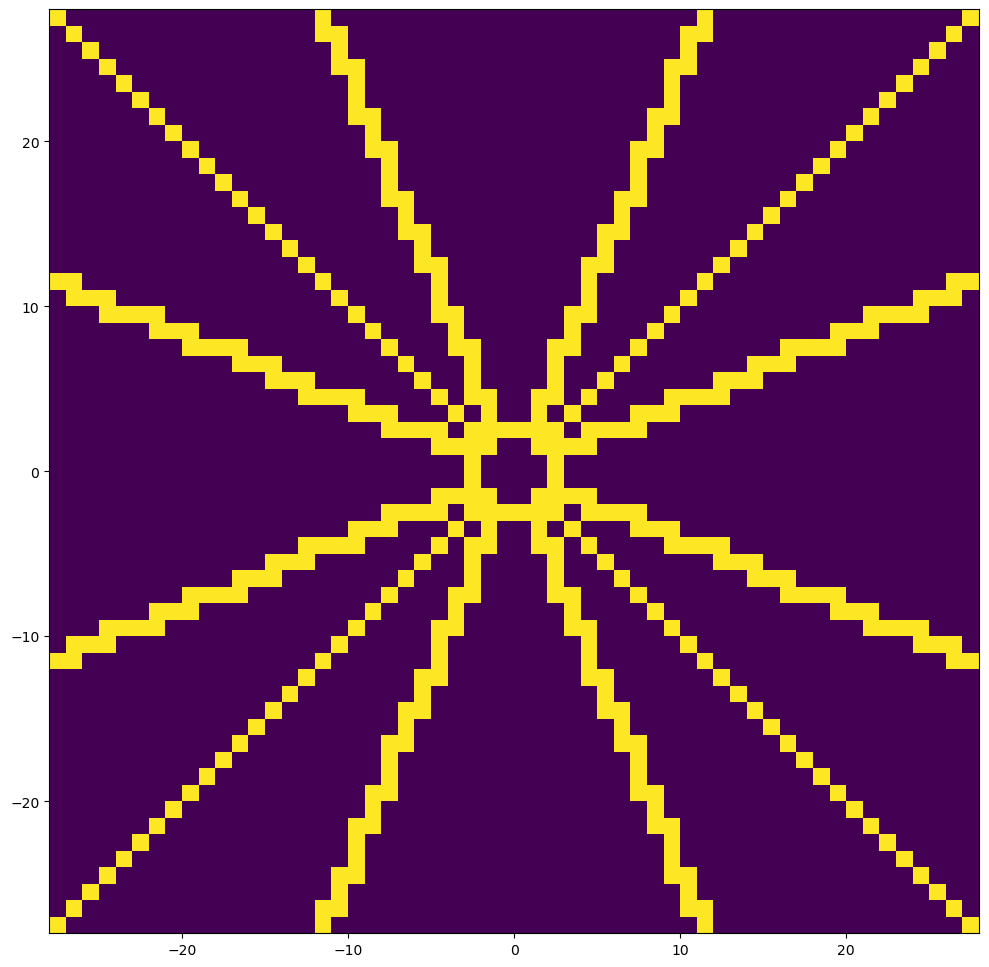

In [7]:
Mask = np.zeros_like(masks[0], dtype=int)
for mask in masks:
    Mask += mask.astype(int)
Mask = Mask>1
fig, ax = plt.subplots(1,1, figsize=(12, 12))
ax.pcolormesh(x2, y2, Mask, cmap='viridis')


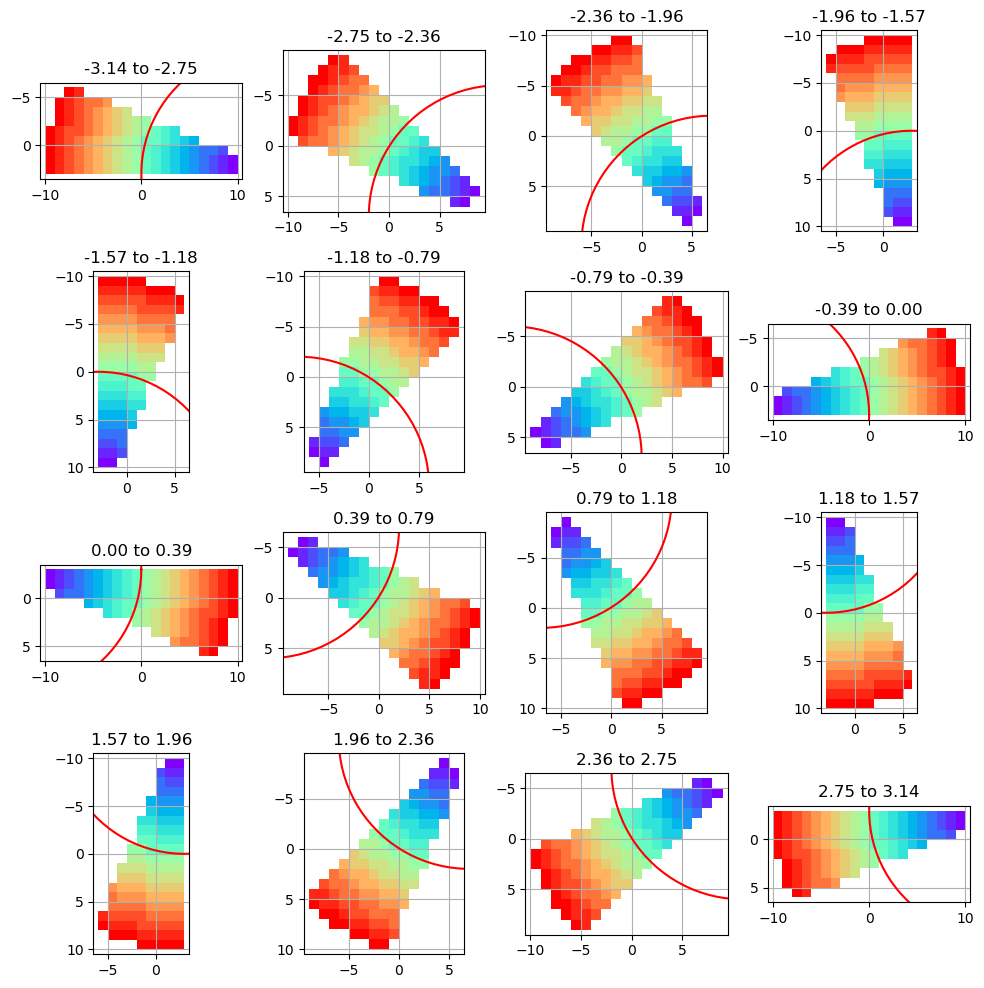

In [8]:
Data = []
for _ in range(16):
    Data.append(dict())

for i, mask in enumerate(masks):
    distance_mask = (r2 * mask).copy()
    distance_mask[np.logical_not(mask)] = np.nan
    Data[i].update({'distance_mask': distance_mask})
    normals = normals2.copy()
    normals[:, np.logical_not(mask)] = np.nan
    Data[i].update({'normals': normals})
    
for i, (angle1, angle2) in enumerate(angle_pairs):
    angle = (angle1 + angle2) / 2
    x = np.round(np.cos(angle) * r)
    y = np.round(np.sin(angle) * r)
    Data[i].update({'center': (x, y)})
    x_coords = x2 - x
    y_coords = y2 - y
    Data[i].update({'coords': (x_coords, y_coords)})
    
for i, mask in enumerate(masks):
    mask_overlap = np.logical_and(Mask > 1, mask)
    Data[i].update({'overlap': mask_overlap})
    
fig, axs = plt.subplots(4,4, figsize=(12, 12))
for i, data_dict in enumerate(Data):
    distance_mask = data_dict['distance_mask']
    x_coords, y_coords = data_dict['coords']
    x0, y0 = data_dict['center']
    ax = axs[i//4, i%4]
    ax.pcolormesh(x_coords, y_coords, distance_mask, cmap='rainbow')
    ax.plot(x_circle-x0, y_circle-y0, color='red')
    ax.set_aspect('equal')
    ax.set_title(f'{angle_pairs[i][0]:.2f} to {angle_pairs[i][1]:.2f}')
    xmin, xmax =np.min(x2[np.isfinite(distance_mask)] - x0), np.max(x2[np.isfinite(distance_mask)] - x0)
    ymin, ymax =np.min(y2[np.isfinite(distance_mask)] - y0), np.max(y2[np.isfinite(distance_mask)] - y0)
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-1, ymax+1)
    ax.grid()
    ax.invert_yaxis()

# Write curved rail masks to lua

In [9]:
directory  = '../scripts/masks/'
try:
    os.makedirs(directory)
except FileExistsError:
    pass


In [10]:
def construct_mask_dict(directions, flip, Data):
    masks = dict()
    for i, direction in enumerate(directions):
        dict_mask = dict()
        for d in range(extent, -extent-1, -1):
            if d == 0:
                continue
            distance_mask = Data[i]['distance_mask']
            overlap = Data[i]['overlap']
            normals2 = Data[i]['normals']
            x2, y2 = Data[i]['coords']
            where = np.where(distance_mask == d)
            elements = []
            for x, y in zip(*where):
                pos = tuple(np.round(np.array([x2[x,y]-0.5, y2[x,y]-0.5])).astype(int))
                if flip[i]:
                    normal = tuple(normals2[:, x, y] * -1)
                else:
                    normal = tuple(normals2[:, x, y])
                elements.append({"pos": pos, "o": overlap[x, y], "n": normal})
            if flip[i]:
                dict_mask[-d] = elements
            else:
                dict_mask[d] = elements

        masks[direction] = dict_mask
    
    return masks

In [11]:
i_curved_rails_a = [0, 3, 4, 7, 8, 11, 12, 15]
i_curved_rails_b = [1, 2, 5, 6, 9, 10, 13, 14]
curved_rail_directions = [2, 12, 6, 0, 10, 4, 14, 8]
curved_rail_flipping = [True, False, True, False, True, False, True, False]

curved_rails_a = [Data[i] for i in i_curved_rails_a]
offsets = [[0,-1], [-1,0], [1,0], [0,-1], [0,1], [1,0], [-1,0], [0,1]]
for i, data in enumerate(curved_rails_a):
    x_coords, y_coords = data['coords']
    x_offset, y_offset = offsets[i]
    x_coords += x_offset
    y_coords += y_offset
    data.update({'coords': (x_coords, y_coords)})
    
    
curved_rails_b = [Data[i] for i in i_curved_rails_b]

mask_dict_a = construct_mask_dict(curved_rail_directions, curved_rail_flipping, curved_rails_a)
mask_dict_b = construct_mask_dict(curved_rail_directions, curved_rail_flipping, curved_rails_b)

mask_dict_to_lua(mask_dict_a, directory + 'curved_rail_a.lua')
mask_dict_to_lua(mask_dict_b, directory + 'curved_rail_b.lua')


# Straight and Half-Diagonal Rails

In [12]:
def straight_rail_mask_generator(width, angle, overlap_whitelist):
    x2, y2 = np.mgrid[-15.5:16.5, -15.5:16.5]
    d2 = x2 * np.cos(angle) + y2 * np.sin(angle)
    d2_bool = np.zeros_like(d2, dtype=bool)
    overlap = np.zeros_like(d2, dtype=int)
    for x_offset in [-0.5, 0.5]:
        for y_offset in [-0.5, 0.5]:
            width2 = np.round((x2+x_offset) * np.sin(angle) - (y2+y_offset) * np.cos(angle), 4)
            tmp_boole = np.logical_and(width2 > -width, width2 < width)
            overlap += tmp_boole.astype(int)
            
    overlap_ = np.zeros_like(d2, dtype=bool)
    for overlap_value in overlap_whitelist:
        overlap_ = np.logical_or(overlap_, overlap == overlap_value)
    
    d2_bool = np.logical_and(d2 >= -extent, d2 <= extent)
    d2_bool = np.logical_and(d2_bool, overlap > 1)
    overlap = np.logical_and(overlap_, d2_bool)   
    
    d2_rounded = symetric_round(d2)
    d2_rounded[np.logical_not(d2_bool)] = np.nan
    d2_rounded[d2_rounded == 0] = np.sign(d2[d2_rounded == 0])
    d2_rounded[d2_rounded == 0] = np.nan
    
    normal = np.array([np.sin(angle), np.cos(angle)])
    normals2 = np.ones_like(x2)[None, :,:] * normal[:, None, None]   
    
    data = dict()
    data['distance_mask'] = d2_rounded
    data['overlap'] = overlap
    data['normals'] = normals2
    data['coords'] = (x2, y2)
    return data

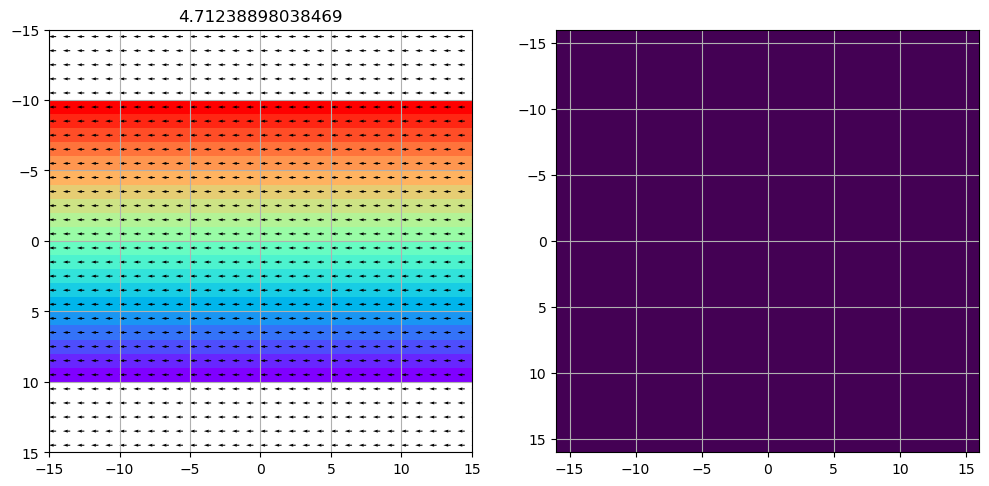

In [21]:
angle = 3*np.pi /2
width = 16
data = straight_rail_mask_generator(width, angle, [3])
x_, y_ = data['coords']
d_ = data['distance_mask']
overlap = data['overlap']
normals_ = data['normals']


fig, axs = plt.subplots(1,2, figsize=(12, 12))
for ax in axs:
    ax.set_aspect('equal')
    ax.grid()
    ax.invert_yaxis()

ax = axs[0]
ax.pcolormesh(x_, y_, d_, cmap='rainbow')
ax.set_title(f'{angle}')

ax.quiver(x_, y_, normals_[0], normals_[1], color='black')
ax.set_xlim(-15, 15)
ax.set_ylim(15, -15)


ax = axs[1]
ax.pcolormesh(x_, y_, overlap, cmap='viridis')

In [14]:
straight_data = []
straight_data.append(straight_rail_mask_generator(1, 0, [3]))
straight_data.append(straight_rail_mask_generator(2**0.5, np.pi/4, [3]))
straight_data.append(straight_rail_mask_generator(1, np.pi/2, [3]))
straight_data.append(straight_rail_mask_generator(2**0.5, 3*np.pi/4, [3]))

straight_rail_directions = [0, 2, 4, 6]
straght_rail_flipping = [True, False, True, False]
mask_dict_straight = construct_mask_dict(straight_rail_directions, straght_rail_flipping, straight_data)
mask_dict_to_lua(mask_dict_straight, directory + 'straight_rail.lua')

SyntaxError: invalid syntax (1829399742.py, line 7)

In [217]:
half_diagonal_data = []
filters = [1, 2, 3]
half_diagonal_data.append(straight_rail_mask_generator(5**0.5, -np.pi/8, filters))
half_diagonal_data.append(straight_rail_mask_generator(5**0.5, np.pi/8, filters))
half_diagonal_data.append(straight_rail_mask_generator(5**0.5, -5*np.pi/8, filters))
half_diagonal_data.append(straight_rail_mask_generator(5**0.5, 5*np.pi/8, filters))

half_diagonal_directions = [0, 2, 4, 6]
half_diagonal_rail_flipping = [False, False, True, False]
mask_dict_half_diagonal = construct_mask_dict(half_diagonal_directions, half_diagonal_rail_flipping, half_diagonal_data)
mask_dict_to_lua(mask_dict_half_diagonal, directory + 'half_diagonal_rail.lua')

# Ramp

In [22]:
ramps_data = []
ramps_data.append(straight_rail_mask_generator(16, 0, [3]))
ramps_data.append(straight_rail_mask_generator(16, np.pi/2, [3]))
ramps_data.append(straight_rail_mask_generator(16, np.pi, [3]))
ramps_data.append(straight_rail_mask_generator(16, 3*np.pi/2, [3]))

ramps_directions = [0, 2, 4, 6]
ramps_flipping = [False, False, False, False]
mask_dict_ramps = construct_mask_dict(ramps_directions, ramps_flipping, ramps_data)
mask_dict_to_lua(mask_dict_ramps, directory + 'rail_ramp.lua')